# Práctico N° 2 Análisis de Grafos - Actividad 5

Integrantes: Nicolás Benjamín Ocampo, Antonela Sambuceti

## Configuración inicial

In [176]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


In [177]:
import pandas as pd
import numpy as np
import io

import seaborn as sn
import matplotlib.pyplot as plt
import math
#from cdlib import NodeClustering, evaluation, algorithms
#import igraph as ig
import networkx as nx
#import pickle

from nltk import (corpus, tokenize, download)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
download("stopwords")
download('punkt')

import numpy as np
import networkx as nx

from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Cargamos el grafo

In [178]:
from google.colab import files
uploaded = files.upload()

Saving larg_G.edgelist to larg_G (1).edgelist


In [179]:
larg_G = nx.read_edgelist('larg_G.edgelist')

In [180]:
larg_G

### Cargamos el dataset de etiquetas y comunidades

In [183]:
from google.colab import files
uploaded = files.upload()

Saving etiq.csv to etiq (1).csv


In [184]:
dtypes = {'user': str}
df_etiq = pd.read_csv(io.StringIO(uploaded['etiq.csv'].decode('utf-8')),dtype=dtypes)

Importamos los usuarios pertenecientes a las dos principales comunidades que obtuvimos a través del algoritmo de Louvain con parámetro de resolución 2.

In [185]:
from google.colab import files
uploaded = files.upload()

Saving comm_1.csv to comm_1 (3).csv


In [186]:
dtypes = {'comm_1': str}
comm_1 = pd.read_csv(io.StringIO(uploaded['comm_1.csv'].decode('utf-8')),dtype=dtypes)

In [187]:
from google.colab import files
uploaded = files.upload()

Saving comm_2.csv to comm_2 (2).csv


In [188]:
dtypes = {'comm_2': str}
comm_2 = pd.read_csv(io.StringIO(uploaded['comm_2.csv'].decode('utf-8')),dtype=dtypes)

## Actividades

## 5. Embedding de nodos
Generar un embedding del grafo de retweets utilizando el algoritmo word2vec.
Reducir a 2 la dimensionalidad del embedding utilizando PCA y t-SNE.
Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

Opcional: Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

In [189]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Generamos las Matrices esparsas

In [190]:
adj = nx.to_scipy_sparse_matrix(larg_G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)
print(edge_index.shape)

torch.Size([2, 186464])


Algoritmo Node2Vec

In [191]:
## Definimos nuestro modelo
model = Node2Vec(
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5
).to(device)

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True)

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

In [192]:
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        ## Reseteamos los gradientes
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

In [193]:
epochs = 20
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 6.483
Epoch:   5 - Loss: 1.684
Epoch:  10 - Loss: 0.975
Epoch:  15 - Loss: 0.888


In [194]:
def get_embedding():
    model.eval()
    with torch.no_grad():
        nodes = torch.arange(larg_G.number_of_nodes(), device=device)
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

In [195]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)

In [196]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

In [197]:
#Generamos las listas de clases y comunidades para graficar 
etiquetas_0 = [i for i, v in enumerate(larg_G.nodes()) if v in (list(df_etiq[df_etiq['Clase']==0]['user']))]
etiquetas_1 = [i for i, v in enumerate(larg_G.nodes()) if v in (list(df_etiq[df_etiq['Clase']==1]['user']))]

comunid_1 = [i for i, v in enumerate(larg_G.nodes()) if v in (list(comm_1['comm_1']))] 
comunid_2 = [i for i, v in enumerate(larg_G.nodes()) if v in (list(comm_2['comm_2']))] 

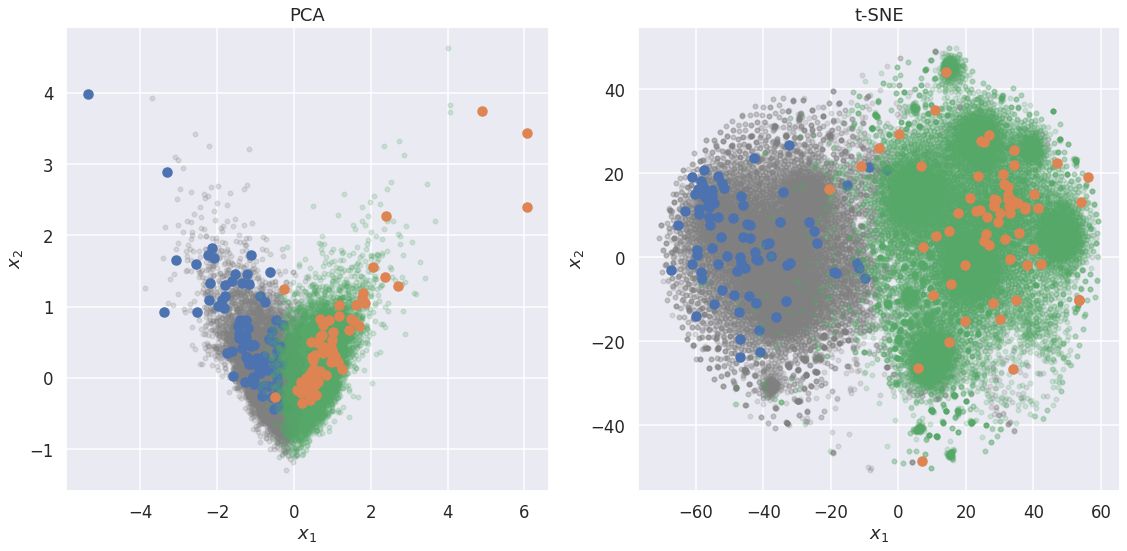

In [198]:
color = 'C0' 
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
x, y = pca[comunid_2][:,0],pca[comunid_2][:,1]
ax.scatter(x,y, c='gray', marker='.', alpha=0.2)
x, y = pca[etiquetas_0][:,0],pca[etiquetas_0][:,1]
ax.scatter(x,y, c='C0')
x, y = pca[comunid_1][:,0],pca[comunid_1][:,1]
ax.scatter(x,y, c='C2', marker='.', alpha=0.2)
x, y = pca[etiquetas_1][:,0],pca[etiquetas_1][:,1]
ax.scatter(x,y, c='C1')

ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
x, y = tsne[comunid_2][:,0],tsne[comunid_2][:,1]
ax.scatter(x,y, c='gray', marker='.', alpha=0.2)
x, y = tsne[etiquetas_0][:,0],tsne[etiquetas_0][:,1]
ax.scatter(x,y,c='C0')
x, y = tsne[comunid_1][:,0],tsne[comunid_1][:,1]
ax.scatter(x,y, c='C2', marker='.', alpha=0.2)
x, y = tsne[etiquetas_1][:,0],tsne[etiquetas_1][:,1]
ax.scatter(x,y,c='C1')

plt.tight_layout()
plt.show()

Podemos observar en los gráficos en 2 dimensiones, tanto con PCA como con TSNE, como el algoritmo de Node2Vec logró diferenciar la clase 0 de la clase 1 (que representan mayor apoyo entre usuarios del grafo). 

A su vez, también vemos como logró captar las dos grandes comunidades a las cuales pertenecen casi la totalidad de los usuarios representados por las 0 y 1.  